# Generation of results for the simulations of semi-automated title-abstract screening

This notebook contains the code for generation of the results. <br>

#### Part I: Set-up
- **1. Import the packages and functions**
- **2. Import the intervention and prognsos review datasets** <br>

#### Part II: Simulations with original review datasets 
- **3. Retrieve and merge the output from all simulations** 
<br>The simulations using the imported datasets were previously run with a seperate code on a High Performance Computer (HPC). The simulations were run for variations of: the 12 datasets, 2 feature extraction models + 3 classification models ( = 5 model combinations), and 200 randomly sampled initial training data. This resulted in 12*5*200 ( = 12000) simulations stored in the same number of pickle files (.p). Each of these files consists of a ranking from simulating the semi-automated screening with the respective dataset and modeling methods. All these files are loaded and the output stored for futher processing.
- **4. Compute performance metrics from the retrieved simulation output**
<br>The retrieved output is then used to calculate the performance metrics (recall, precision, WSS etc.) for each of the simulations.
- **5. Create raw tables with all performance metrics seperately** 
- **6. Process raw tables into pooled tabels (for results)**
- **7. Create histograms for WSS and precision (for results)** 
- **8. Create boxplots/lineplots of increasing recall during screening (for results)** <br>

#### Part III: Simulations with adapted review datasets 

## Part I: Set-up

### 1. Import the packages and functions

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import pickle
import os
import shutil
import math
import seaborn as sns
import matplotlib.pyplot as plt
import argparse
import collections

In [2]:
from functions import compute_metrics, compute_nwss
from functions import generate_recall_table_prop, generate_recall_table_ss, max_recall_prop, max_recall_ss
from functions import generate_wss_table, generate_results_table

In [3]:
from asreview.models.classifiers import LogisticClassifier, LSTMBaseClassifier, LSTMPoolClassifier, NaiveBayesClassifier, NN2LayerClassifier, RandomForestClassifier, SVMClassifier
from asreview.models.query import ClusterQuery, MaxQuery, MaxRandomQuery, MaxUncertaintyQuery, RandomQuery, UncertaintyQuery
from asreview.models.balance import DoubleBalance, SimpleBalance, UndersampleBalance
from asreview.models.feature_extraction import Doc2Vec, EmbeddingIdf, EmbeddingLSTM, SBERT, Tfidf
from asreview import open_state

from pathlib import Path

In [5]:
# TODO put results in correct folders
path_data = 'data/' 
path_results_HPC = '/Users/ispiero2/Documents/Research/Results_HPC/'
path_results = '/Users/ispiero2/Documents/Research/Results_tmp/' 

### 2. Import the intervention and prognosis review datasets

The intervention review datasets that were used for simulation are imported (numbering of the datasets is ordered by authors), and the prognosis review datasets that were used for simulation are imported (numbering of the datasets is ordered by author, so numbers do not correspond to numbers in data prep):

In [6]:
# Load all the review datasets in the dataset containing folder into a dictionary
review_dic = {}

for file_name in os.listdir(path_data):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(path_data, file_name)
        df = pd.read_excel(file_path)
        key = os.path.splitext(file_name)[0].split("_")[0]
        review_dic[key] = df

review_dic = dict(sorted(review_dic.items()))

In [8]:
# Create separate dictionaries for intervention and prognosis review datasets
dfs_int = {key: value for key, value in review_dic.items() if key.startswith('Int')}
dfs_prog = {key: value for key, value in review_dic.items() if key.startswith('Prog')}

## Part II: Simulations with original review datasets

### 3. Retrieve and merge the output from all simulations

To assess the performance of the semi-automated screening tool, not only the reviews, but also the classification models, feature extraction models, and/or query models were varied in the simulations:

In [9]:
# Specify the the classification, feature extraction, and query model(s) that were tested
train_models = [LogisticClassifier(), NaiveBayesClassifier(), SVMClassifier()] 
feature_models = [Tfidf(), SBERT()] 
query_models = [MaxQuery()]

# Specify the number of simulations per review-model combination  
n_simulations = 200 

All the output from the simulations of these variations (conducted on the HPC) can then be retrieved and merged as follows:

In [10]:
# Create a list of the review-model combination names
sim_list_names = []
for review in review_dic:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                review_id = str(review + "_" + train_model.name + "_" + feature_model.name + "_" + query_model.name)
                sim_list_names.append(review_id)
                
# Retrieve the output from the HPC generated pickle files with each having the rankings of a single simulation
multiple_sims = []
for i in range(0, len(sim_list_names)):
    raw_output = {}
    for j in range(1,n_simulations+1):
        if Path(path_results_HPC +'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j)).is_file():
            with open(path_results_HPC + 'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names[i], sim=j),'rb') as f:
                raw_output.update(pickle.load(f))
    if len(raw_output) > 0:
        multiple_sims.append((sim_list_names[i], len(review_dic[sim_list_names[i].split('_')[0]]), n_simulations, raw_output))

In [11]:
# Save (back-up) the file with the simulation results 
# with open(path_results + 'multiple_sims_saved_all_final.p','wb') as f:
#     pickle.dump(multiple_sims, f)

or the output can be directly opened from the already saved file:

In [18]:
# Open the file with the simulation results
with open(path_results + 'multiple_sims_saved_all_final.p','rb') as f:
    multiple_sims = pickle.load(f)

The output can be separated in dictionaries for the prognosis reviews and intervention reviews each:

In [19]:
# Distinguish between the intervention and prognosis reviews by creating a separate dictionary for each
multiple_sims_prog = multiple_sims[0:35]
multiple_sims_int = multiple_sims[35:75]

### 4. Compute performance metrics from the retrieved simulation output

The proportions (i.e. proportion of records screened) and sample sizes (i.e. the number of records screened) of interest can be defined. These are then used for evaluation of the ranking of the records and to calculate the performance metrics at each of these proportions/sample sizes screened.

In [20]:
proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sample_sizes = list(map(int,list(np.linspace(0, 99, 100,retstep = True)[0]))) + list(map(int,list(np.linspace(100, 12400, 124,retstep = True)[0])))

Using these proportions and sizes, the following function can be used to derive the performance metrics of the simulation(s):

In [21]:
# Use the compute_metrics function to compute the metrics from the retrieved simulation output
#raw_output = compute_metrics.compute_metrics(multiple_sims, proportions, sample_sizes)

In [22]:
# Save (back-up) a file with the computed output
# with open(path_results + 'sims_output_saved_all_final_extra.p','wb') as f:
#     pickle.dump(raw_output, f)

and the normalized work-saved-over sampling metric: (TODO merge this with the compute_metrics function):

In [23]:
# Use the compute_nwss function to derive the normalized WSS of the retrieved simulation output
#raw_output_nwss = compute_nwss.compute_nwss(multiple_sims, proportions, sample_sizes)

In [24]:
# Save (back-up) a file with the computed output
# with open(path_results + 'sims_output_saved_all_nwss_final.p','wb') as f:
#     pickle.dump(raw_output_nwss, f)

Or directly open the file containing the output (as these especially take a while to run):

In [25]:
# Open the file with the computed output
with open(path_results + 'sims_output_saved_all_final_extra.p','rb') as f:
    raw_output = pickle.load(f)

In [26]:
# Open the file with the computed output
with open(path_results + 'sims_output_saved_all_nwss_final.p','rb') as f:
    raw_output_nwss = pickle.load(f)

### 5. Create raw tables with all performance metrics seperately

Filter the (for now) relevant parts of the output for the results:

In [46]:
evaluation = {}
for i in range(0, len(raw_output)):
    evaluation[raw_output[i][0]] = []
    evaluation[raw_output[i][0]].append(raw_output[i][3:8])
    
import warnings
warnings.filterwarnings('ignore')

In [47]:
evaluation_nwss = {}
for i in range(0, len(raw_output_nwss)):
    evaluation_nwss[raw_output_nwss[i][0]] = []
    evaluation_nwss[raw_output_nwss[i][0]].append(raw_output_nwss[i][3:])
    
import warnings
warnings.filterwarnings('ignore')

Create a raw table with the performance metrics for proportions:

In [96]:
# Use the generate_recall_table_prop function to generate a table with all recall values for all proportions
df_prop = generate_recall_table_prop.generate_recall_table_prop(evaluation, proportions, n_simulations)
df_prop.head()

,Review,Simulation number,Train model,Feature model,Query model,Simulation,percentage of records screened,recall,Review_full,Models
0,Prog1,1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),0%,0.000000,Prognosis 1,tfidf - logistic
1,Prog1,1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),10%,0.470199,Prognosis 1,tfidf - logistic
2,Prog1,1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),20%,0.754967,Prognosis 1,tfidf - logistic
3,Prog1,1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),30%,0.907285,Prognosis 1,tfidf - logistic
4,Prog1,1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),40%,0.953642,Prognosis 1,tfidf - logistic


Calculate the maximum recall values that could be obtained at each of the proportions screened

In [97]:
# Sort the dictionary
review_dic_ord = collections.OrderedDict(sorted(review_dic.items()))
# Use the max_recall_prop function to calculate the maximum achievable recall for each review
df_max_recalls = max_recall_prop.max_recall_prop(review_dic_ord, proportions)
df_max_recalls.head()

,Review,Maximum recall
0,Int1,0.0
1,Int1,1.0
2,Int1,1.0
3,Int1,1.0
4,Int1,1.0


Create a raw table with the performance metrics for sample sizes:

In [98]:
# Use the generate_recall_table_ss function to generate a table with all recall values for all sample sizes
# df_ss = generate_recall_table_ss.generate_recall_table_ss(evaluation, sample_sizes, n_simulations)
# df_ss.head()

In [99]:
# Save (back-up) a file with the computed tables (these take almost a day to compute)
# # Computed table with sample size
# with open(path_results + 'sims_output_saved_all_ss_final.p','wb') as f:
#     pickle.dump(df_ss, f)

Or directly open the file with the sample sizes table:

In [100]:
# Open the computed table with sample size
with open(path_results + 'sims_output_saved_all_ss_final.p','rb') as f:
    df_ss = pickle.load(f)

In [101]:
df_ss.head()

,Review,Train model,Feature model,Query model,Simulation,Number of records screened,Recall,Simulation number,Review_full,Models
0,Prog1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),0,0.00,1,Prognosis 1,logistic - tfidf
1,Prog1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),1,0.00,1,Prognosis 1,logistic - tfidf
2,Prog1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),2,0.01,1,Prognosis 1,logistic - tfidf
3,Prog1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),3,0.01,1,Prognosis 1,logistic - tfidf
4,Prog1,logistic,tfidf,max,Prognosis 1 (logistic - tfidf),4,0.01,1,Prognosis 1,logistic - tfidf


Calculate the maximum recall values that could be obtained at each of the sample sizes screened

In [102]:
# Define the sample sizes (number of records screened) at which to calculate the maximul achievable recalls
sample_sizes_mr = list(map(int,list(np.linspace(0, 12400, 12400,retstep = True)[0])))
# Use the max_recall_ss function to calculate the maximum achievable recall for each review
df_max_recalls_ss = max_recall_ss.max_recall_ss(review_dic_ord, sample_sizes_mr)
df_max_recalls_ss.head()

,Review,Maximum recall
0,Int1,0.00
1,Int1,0.02
2,Int1,0.04
3,Int1,0.06
4,Int1,0.07


Create a raw table with the work-saved-over sampling, normalized work-saved-over sampling, workload reduction in number of records, and workload reduction in hours:

In [103]:
# Use the generate_wss_table function to create a table with the workload metrics
df_wss = generate_wss_table.generate_wss_table(evaluation, evaluation_nwss, n_simulations)
df_wss.head()
#df_wss.to_excel('Table_wss.xlsx')

,Review,Train model,Feature model,Query model,Simulation,WSS@95%,n-WSS@95%,Workload reduction (n),Workload reduction (hours)
0,Prog1,logistic,tfidf,max,1,0.564827,0.690278,1526,12.7
1,Prog1,logistic,tfidf,max,2,0.562006,0.687037,1519,12.7
2,Prog1,logistic,tfidf,max,3,0.541861,0.663889,1469,12.2
3,Prog1,logistic,tfidf,max,4,0.570064,0.696759,1539,12.8
4,Prog1,logistic,tfidf,max,5,0.574899,0.702315,1551,12.9


Create a raw table with the precision metric:

In [104]:
df_prec = pd.DataFrame()
length = n_simulations
for key, value in evaluation.items():
    names = key.split('_')
    review = [names[0]] * length
    train_model = [names[1]] * length
    feature_model = [names[2]] * length
    query_model = [names[3]] * length
    simulations = range(1, n_simulations+1)
    precision = value[0][4]['Precision'] ###
    df_sim = pd.DataFrame(list(zip(review,train_model,feature_model,query_model,simulations, precision)),
                           columns = ['Review', 'Train model', 'Feature model', 'Query model', 'Simulation', 'Precision@95%'])
    df_prec = pd.concat([df_prec, df_sim])

    df_prec = df_prec.reset_index(drop = True)

df_prec.head()

,Review,Train model,Feature model,Query model,Simulation,Precision@95%
0,Prog1,logistic,tfidf,max,1,0.303347
1,Prog1,logistic,tfidf,max,2,0.301142
2,Prog1,logistic,tfidf,max,3,0.287266
3,Prog1,logistic,tfidf,max,4,0.307529
4,Prog1,logistic,tfidf,max,5,0.311493


### 6. Process raw tables into pooled tables (for results)

Create a table with the results of wss/workload reduction and precision combined:

In [105]:
df_wss_prec_all_values, df_wss_prec = generate_results_table.generate_results_table(df_wss, df_prec)
#df_wss_prec.to_excel('Table_WSS_precision_final_extra.xlsx')
df_wss_prec_all_values.head()

,Review,Train model,Feature model,Mean_WSS95,ci95_hi_WSS95,ci95_lo_WSS95,Mean_nWSS95,ci95_hi_nWSS95,ci95_lo_nWSS95,Mean_prec95,ci95_hi_prec95,ci95_lo_prec95,Mean_workred_n,ci95_hi_workred_n,ci95_lo_workred_n,Mean_workred_hr,ci95_hi_workred_hr,ci95_lo_workred_hr,Models
0,Int1,logistic,sbert,0.853,0.858,0.848,0.907,0.912,0.902,0.058,0.062,0.053,"8,273",8319,8227,68.9,69.3,68.6,sbert - logistic
1,Int1,logistic,tfidf,0.866,0.867,0.864,0.920,0.921,0.918,0.054,0.055,0.054,"8,386",8398,8374,69.9,70.0,69.8,tfidf - logistic
2,Int1,nb,tfidf,0.863,0.864,0.863,0.917,0.918,0.917,0.054,0.054,0.053,"8,366",8374,8359,69.7,69.8,69.7,tfidf - nb
3,Int1,svm,sbert,0.844,0.850,0.839,0.898,0.904,0.893,0.051,0.054,0.048,"8,193",8243,8144,68.3,68.7,67.9,sbert - svm
4,Int1,svm,tfidf,0.845,0.847,0.843,0.899,0.901,0.897,0.043,0.044,0.042,"8,196",8215,8178,68.3,68.5,68.1,tfidf - svm


In [106]:
df_wss_prec.head()

,Review,Train model,Feature model,WSS@95%recall (CI),n-WSS@95%recall (CI),Precision@95%recall (CI),Workload reduction in record numbers (CI),Workload reduction in hours (CI)
0,Int1,logistic,sbert,0.853 (0.848-0.858),0.907 (0.902-0.912),0.058 (0.053-0.062),"8,273 (8227-8319)",68.9 (68.6-69.3)
1,Int1,logistic,tfidf,0.866 (0.864-0.867),0.920 (0.918-0.921),0.054 (0.054-0.055),"8,386 (8374-8398)",69.9 (69.8-70.0)
2,Int1,nb,tfidf,0.863 (0.863-0.864),0.917 (0.917-0.918),0.054 (0.053-0.054),"8,366 (8359-8374)",69.7 (69.7-69.8)
3,Int1,svm,sbert,0.844 (0.839-0.850),0.898 (0.893-0.904),0.051 (0.048-0.054),"8,193 (8144-8243)",68.3 (67.9-68.7)
4,Int1,svm,tfidf,0.845 (0.843-0.847),0.899 (0.897-0.901),0.043 (0.042-0.044),"8,196 (8178-8215)",68.3 (68.1-68.5)


### 7. Create histograms for WSS and precision (for results)

Remove the output of the reviews that are not included in the results of our study

In [156]:
df_wss_prec_all_values_ed = df_wss_prec_all_values.copy()
df_prop_ed = df_prop.copy()
df_max_recalls_ed = df_max_recalls.copy()

# Remove prognosis review 5 (wrong study design), and change numbering
df_wss_prec_all_values_ed = df_wss_prec_all_values_ed.drop(df_wss_prec_all_values_ed[df_wss_prec_all_values_ed['Review'] == 'Prog5'].index)
df_wss_prec_all_values_ed['Review'] = df_wss_prec_all_values_ed['Review'].replace({'Prog6': 'Prog5',
                                                                                   'Prog7': 'Prog6'})
df_prop_ed = df_prop_ed.drop(df_prop_ed[df_prop_ed['Review'] == 'Prog5'].index)
df_prop_ed['Review'] = df_prop_ed['Review'].replace({'Prog6': 'Prog5',
                                                     'Prog7': 'Prog6'})
df_prop_ed['Review_full'] = df_prop_ed['Review_full'].apply(lambda x: x.replace('Prognosis 6', 'Prognosis 5') if 'Prognosis 6' in x else x)
df_prop_ed['Review_full'] = df_prop_ed['Review_full'].apply(lambda x: x.replace('Prognosis 7', 'Prognosis 6') if 'Prognosis 7' in x else x)
df_prop_ed['Simulation'] = df_prop_ed['Simulation'].apply(lambda x: x.replace('Prognosis 6', 'Prognosis 5') if 'Prognosis 6' in x else x)
df_prop_ed['Simulation'] = df_prop_ed['Simulation'].apply(lambda x: x.replace('Prognosis 7', 'Prognosis 6') if 'Prognosis 7' in x else x)
df_max_recalls_ed = df_max_recalls_ed.drop(df_max_recalls_ed[df_max_recalls_ed['Review'] == 'Prog5'].index)
df_max_recalls_ed['Review'] = df_max_recalls_ed['Review'].replace({'Prog6': 'Prog5',
                                                                   'Prog7': 'Prog6'})

# Remove intervention review 7 and 8 (too few relevant records)
df_wss_prec_all_values_ed = df_wss_prec_all_values_ed.drop(df_wss_prec_all_values_ed[df_wss_prec_all_values_ed['Review'] == 'Int7'].index)
df_wss_prec_all_values_ed = df_wss_prec_all_values_ed.drop(df_wss_prec_all_values_ed[df_wss_prec_all_values_ed['Review'] == 'Int8'].index)
df_prop_ed = df_prop_ed.drop(df_prop_ed[df_prop_ed['Review'] == 'Int7'].index)
df_prop_ed = df_prop_ed.drop(df_prop_ed[df_prop_ed['Review'] == 'Int8'].index)
df_max_recalls_ed = df_max_recalls_ed.drop(df_max_recalls_ed[df_max_recalls_ed['Review'] == 'Int7'].index)
df_max_recalls_ed = df_max_recalls_ed.drop(df_max_recalls_ed[df_max_recalls_ed['Review'] == 'Int8'].index)

Create histograms for (n-)WSS and precision for intervention and prognosis reviews seperately

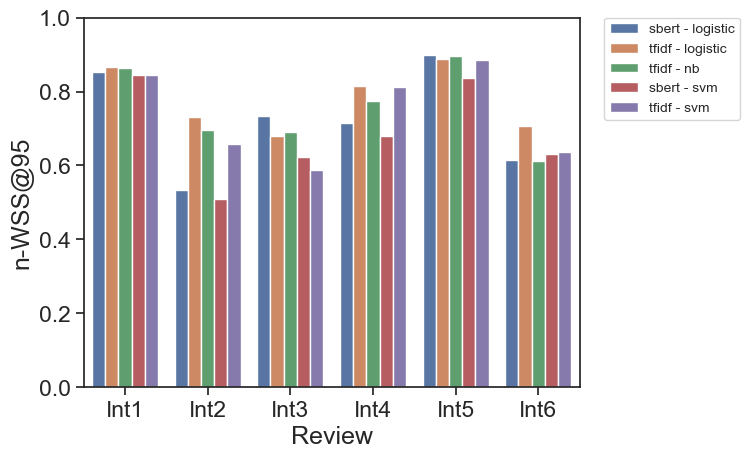

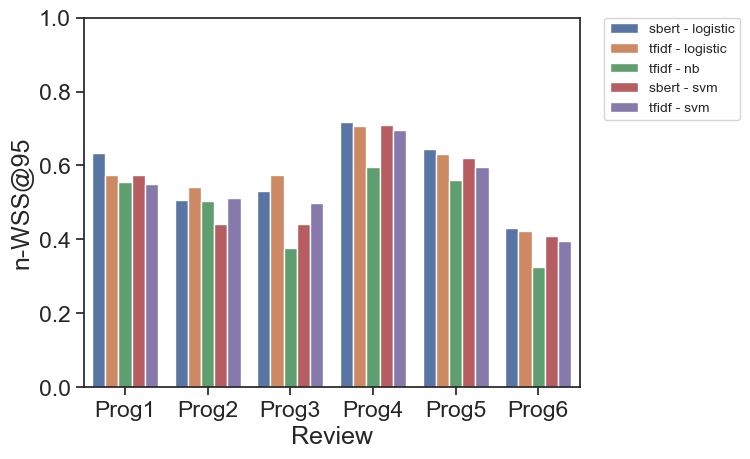

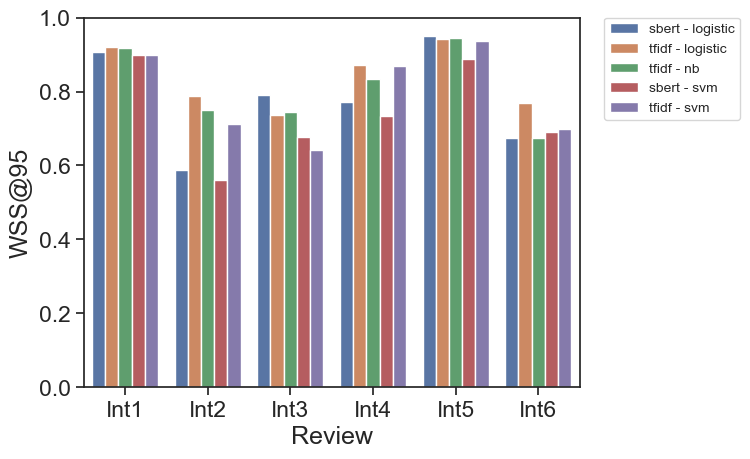

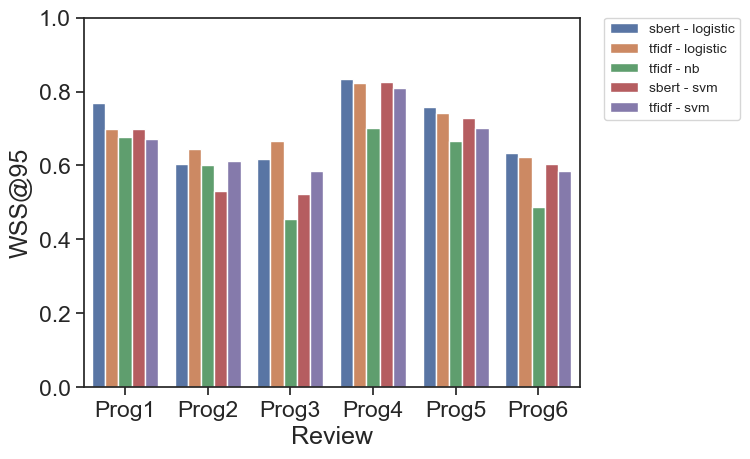

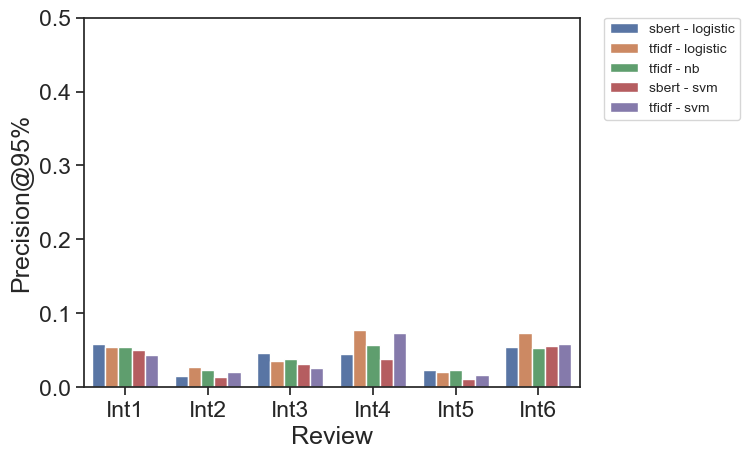

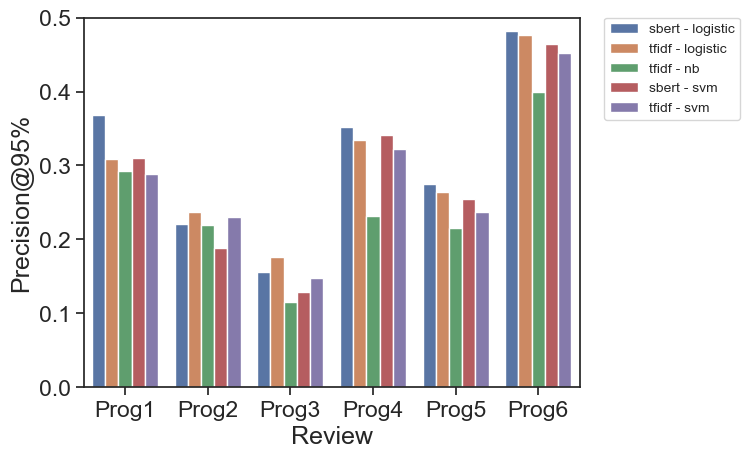

In [145]:
# Choose variables to plot
variables_to_plot = ['Mean_WSS95', 'Mean_nWSS95', 'Mean_prec95']
variable_names = ['n-WSS@95', 'WSS@95', 'Precision@95%']
y_lims = [1,1,0.5]
review_types = ['Int', 'Prog']

def generate_histograms(df_wss_prec_all_values, variables_to_plot, variable_names, review_types):
    
    # Change dtype to numeric
    for variable in variables_to_plot:
        df_wss_prec_all_values[variable] = pd.to_numeric(df_wss_prec_all_values[variable])
        
    # Create a histogram for each variable and review type
    for i in range(0, len(variables_to_plot)):
        for j in review_types:
            
            sns.barplot(x='Review', y=variables_to_plot[i], hue='Models', 
                        data=df_wss_prec_all_values[df_wss_prec_all_values['Review'].str.startswith(j)]).set(ylabel=variable_names[i],ylim=(0,y_lims[i]))
            plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.show()
            
generate_histograms(df_wss_prec_all_values_ed, variables_to_plot, variable_names, review_types)

### 8. Create boxplots/lineplots of increasing recall during screening (for results)

Create boxplots for the simulations of the default models (or any other subset of data/modeling methods):

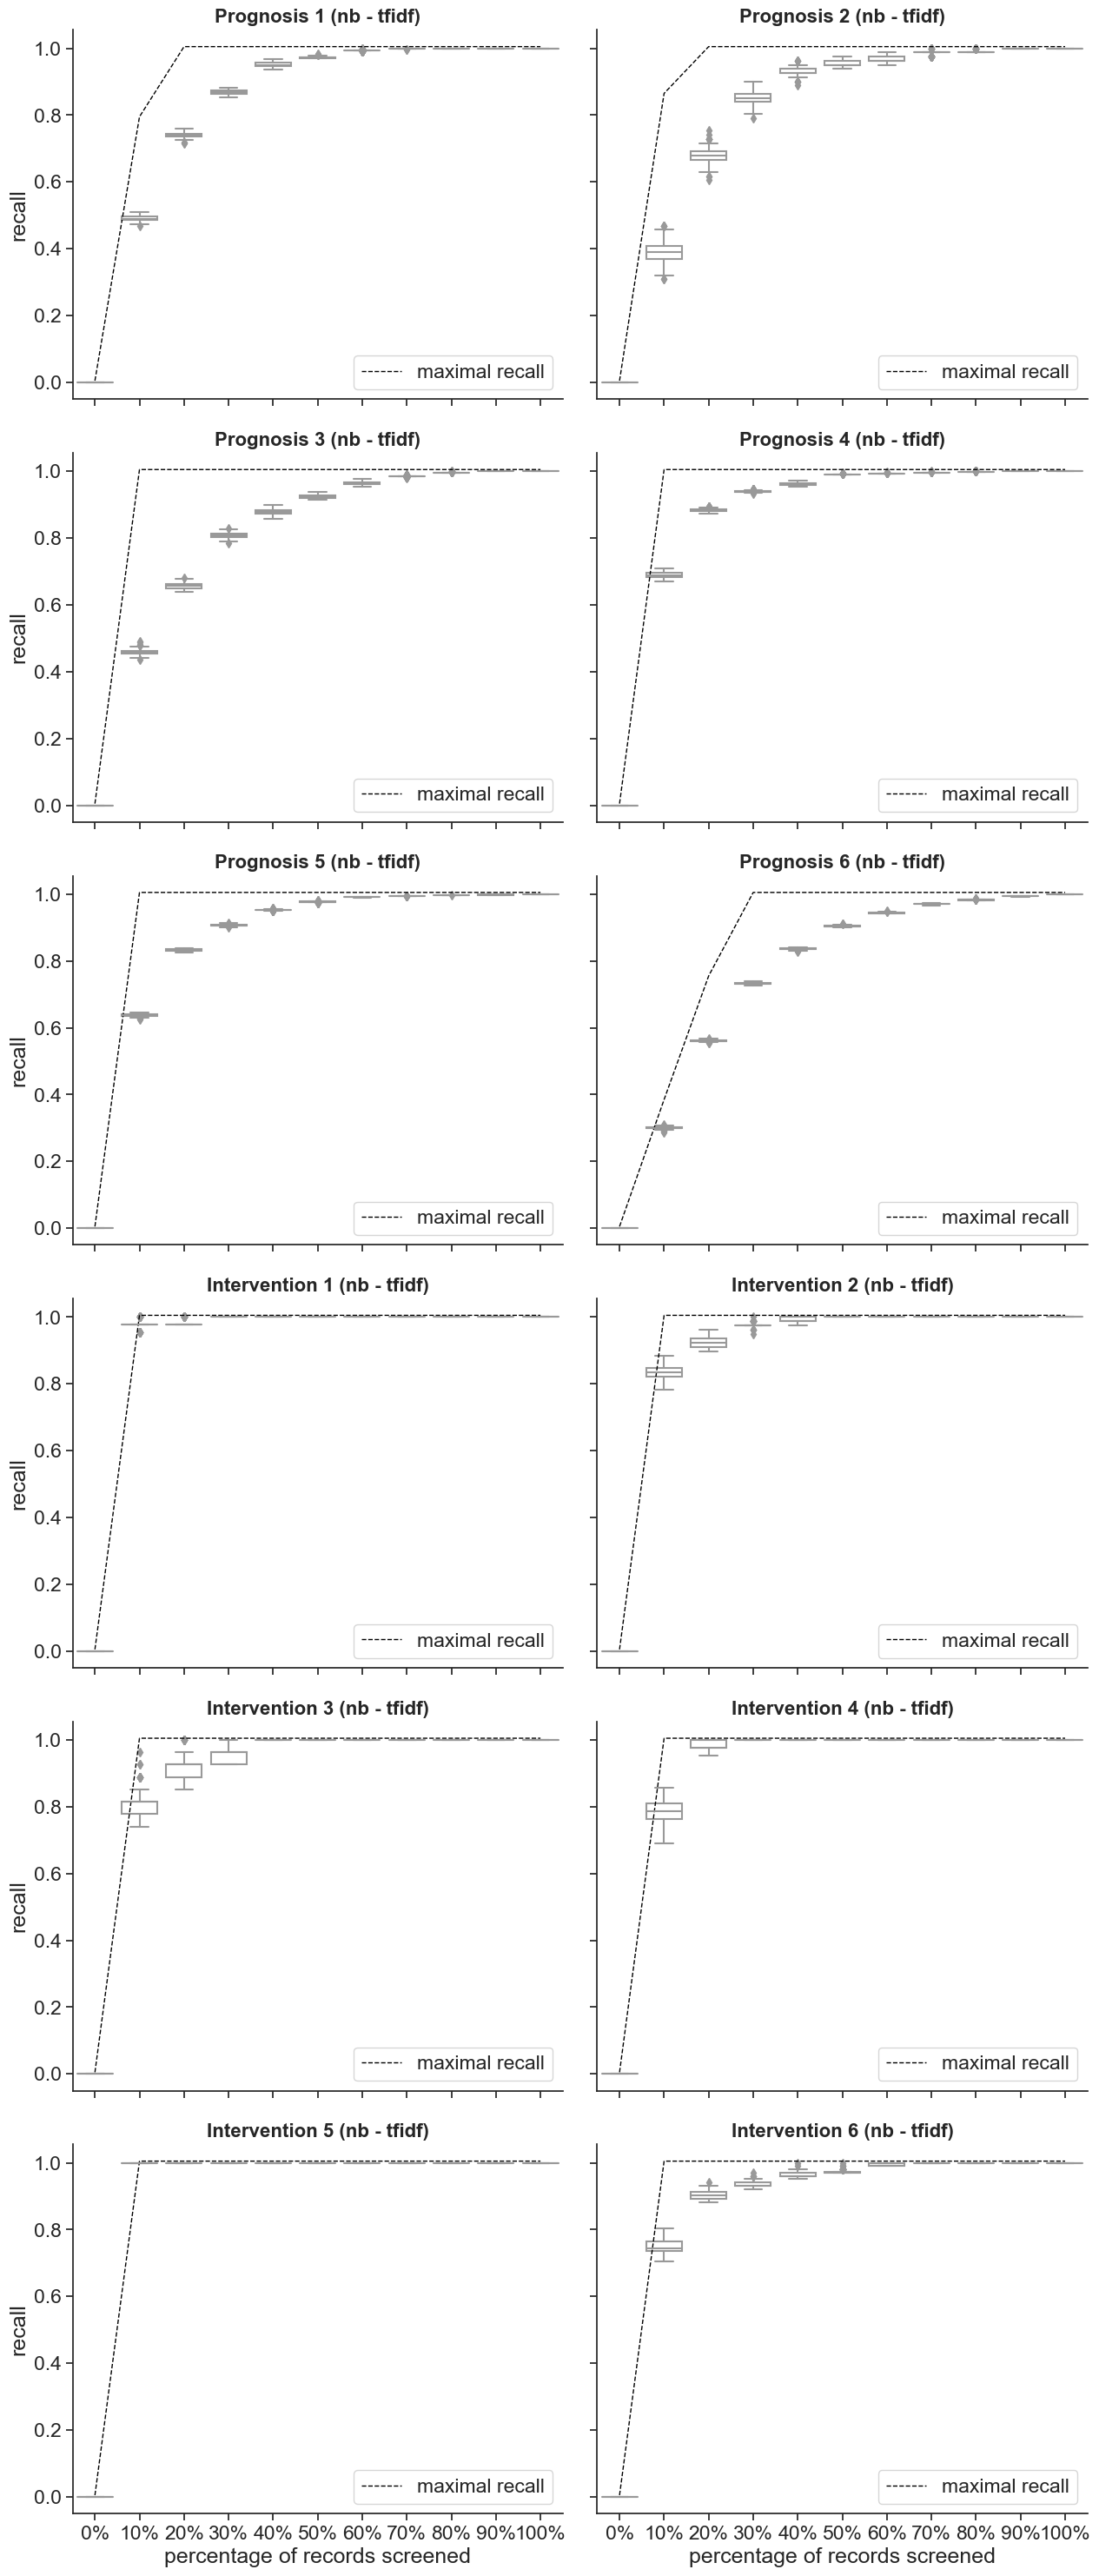

In [147]:
# Optionally choose subset(s) to plot
subset_models = ['nb - tfidf']
subset_reviews = ['Prog', 'Int']

def generate_boxplots(df_prop_ed, subset_models = None, subset_reviews = None):
    
    # Select the subset from the dataframe containing all recall values for each proportion screened
    df_boxplots = df_prop_ed.copy()
    
    if subset_models != None:
        models = '|'.join(subset_models)
        df_boxplots = df_boxplots[df_boxplots['Simulation'].str.contains(models, regex=True)]
    if subset_reviews != None:
        reviews = '|'.join(subset_reviews)
        df_boxplots = df_boxplots[df_boxplots['Review'].str.contains(reviews, regex=True)]

    # Create a figure with boxplots for each review-model combination seperately
    sns.set(style = 'ticks', font_scale = 1.5)
    p1 = sns.catplot(data = df_boxplots, x = 'percentage of records screened', y = 'recall',
                     col = 'Simulation', kind = 'box', col_wrap = 2, color = 'white', aspect = 1.3)

    axes = p1.fig.axes
    x_axis = df_boxplots['percentage of records screened'][0:11]

    for i in range(0, len(df_boxplots['Simulation'].unique())):
        review = df_boxplots.loc[df_boxplots['Simulation'] == df_boxplots['Simulation'].unique()[i], 'Review'].values[0]
        max_recalls_per_prop = df_max_recalls_ed.loc[df_max_recalls_ed['Review'] == review]['Maximum recall']    
        axes[i].plot(x_axis, max_recalls_per_prop+0.005, 'k-', linewidth = 1, color = 'black', linestyle = '--', label = "maximal recall")   
        axes[i].legend(loc="lower right")
    p1.set_titles(col_template = "{col_name}", size = 16, weight = 'bold')

    plt.show()
    
generate_boxplots(df_prop_ed, subset_models, subset_reviews)

Create lineplots for all simulations (or any other subset of data/modeling methods):

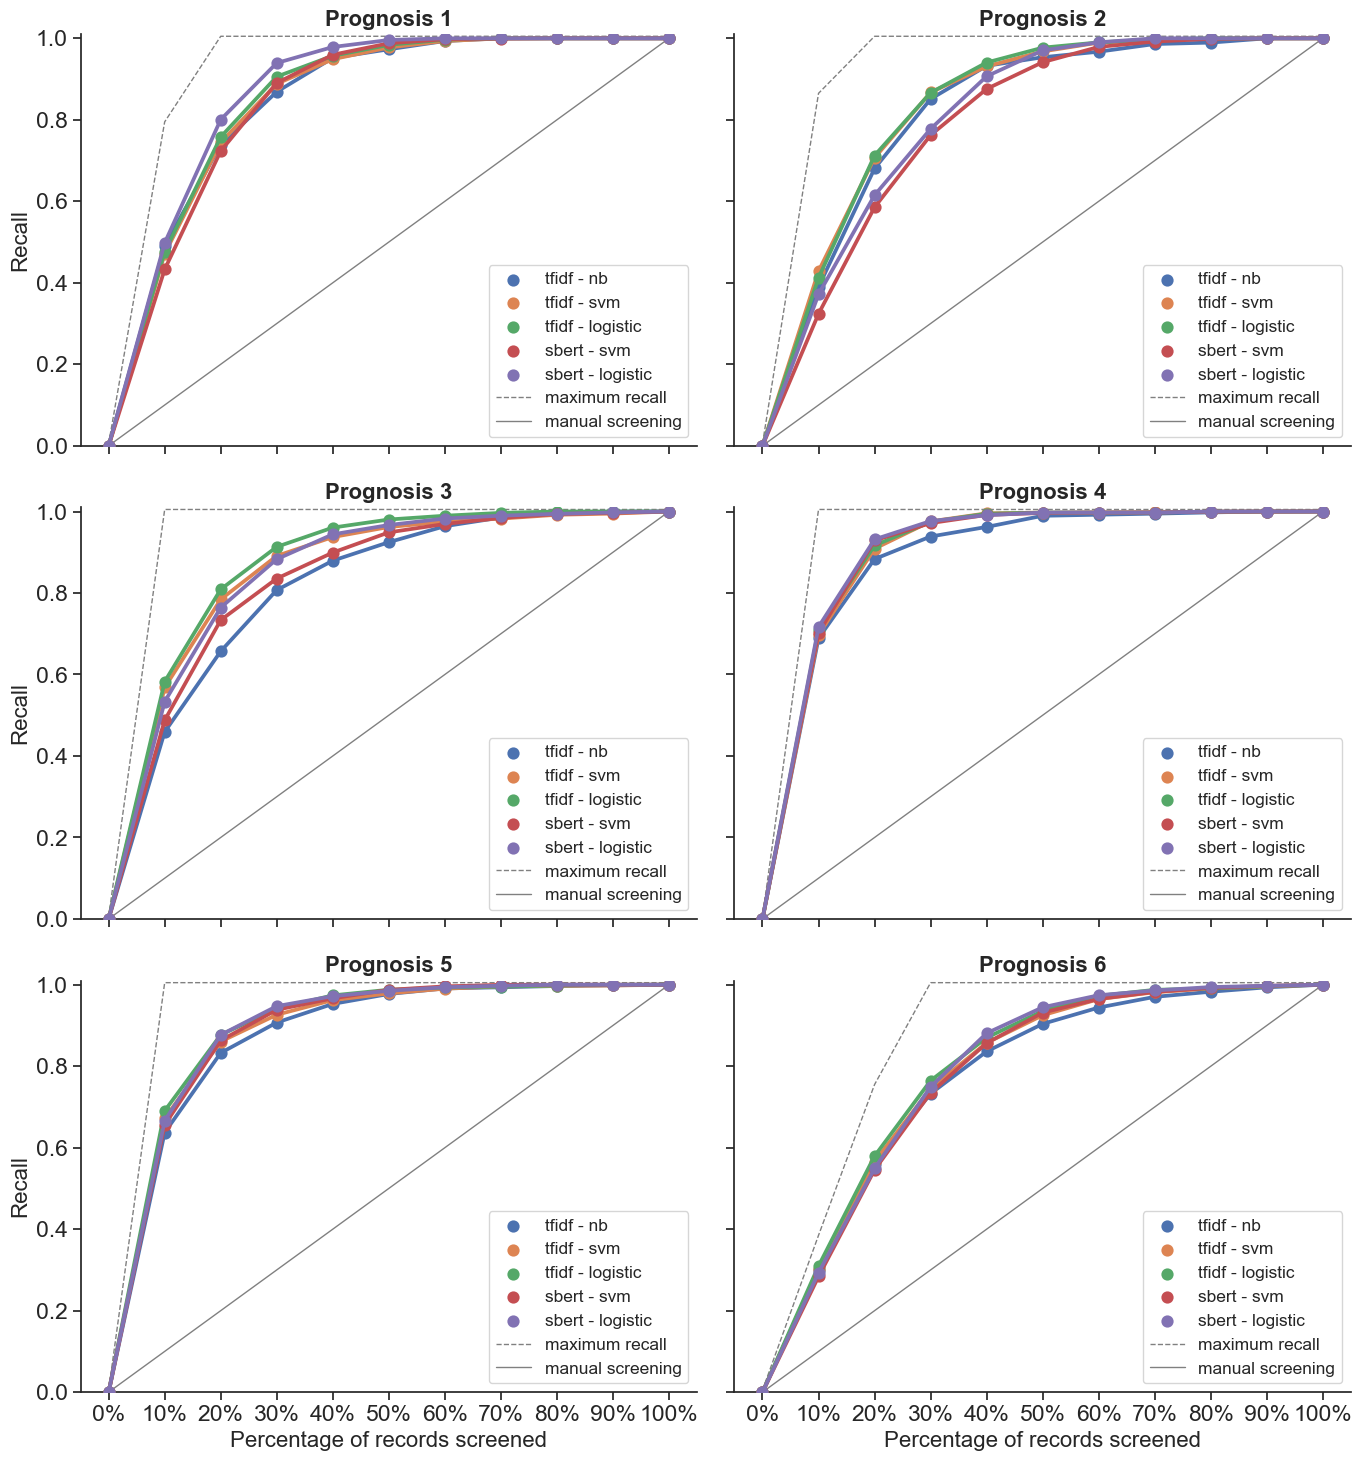

In [165]:
# Optionally choose a subset to plot
subset_reviews = ['Prog']

def generate_lineplots(df_prop_ed, df_max_recalls_ed, subset_reviews = None):
    
    # Select the subset from the dataframe containing all recall values for each proportion screened
    df_lineplots = df_prop_ed.copy()
    
    df_lineplots['Models'] = df_lineplots['Models'].astype(pd.CategoricalDtype(categories=['tfidf - nb',
                                                                  'tfidf - svm',
                                                                  'tfidf - logistic',
                                                                  'sbert - svm',
                                                                  'sbert - logistic']))
    
    if subset_reviews != None:
        reviews = '|'.join(subset_reviews)
        df_lineplots = df_lineplots[df_lineplots['Review'].str.contains(reviews, regex=True)]

    # Create a figure with lineplots for each review-model combination seperately
    p2 = sns.catplot(data = df_lineplots, kind = 'point', 
                     x = 'percentage of records screened', y = 'recall', 
                     col = 'Review_full', 
                     hue = 'Models', 
                     errorbar = 'ci',
                     col_wrap = 2, aspect = 1.4, legend = False
                     )

    axes = p2.fig.axes

    for i in range(0, len(df_lineplots['Review'].unique())):
        max_recalls_per_prop = df_max_recalls_ed.loc[df_max_recalls_ed['Review'] == df_lineplots['Review'].unique()[i]]['Maximum recall']    
        manual_screening = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
        x_axis = df_lineplots['percentage of records screened'][0:len(max_recalls_per_prop)]
        axes[i].plot(x_axis, max_recalls_per_prop + 0.005, 'k-', linewidth = 1, color = 'grey', linestyle = '--', label = "maximum recall") 
        axes[i].plot(x_axis, manual_screening, 'k-', linewidth = 1, color = 'grey', linestyle = '-', label = "manual screening") 
        axes[i].legend(loc="lower right", fontsize = 12.5)
    
    if subset_reviews[0] == 'Int8':
        p2.set_titles('Intervention A1', size = 16, weight = 'bold')
    else:
        p2.set_titles(col_template = "{col_name}", size = 16, weight = 'bold')
    p2.set_xlabels('Percentage of records screened', size = 16)
    p2.set_ylabels('Recall', size = 16)
    p2.set(ylim = (0, 1.01))
    plt.show()

generate_lineplots(df_prop_ed, df_max_recalls_ed, subset_reviews)

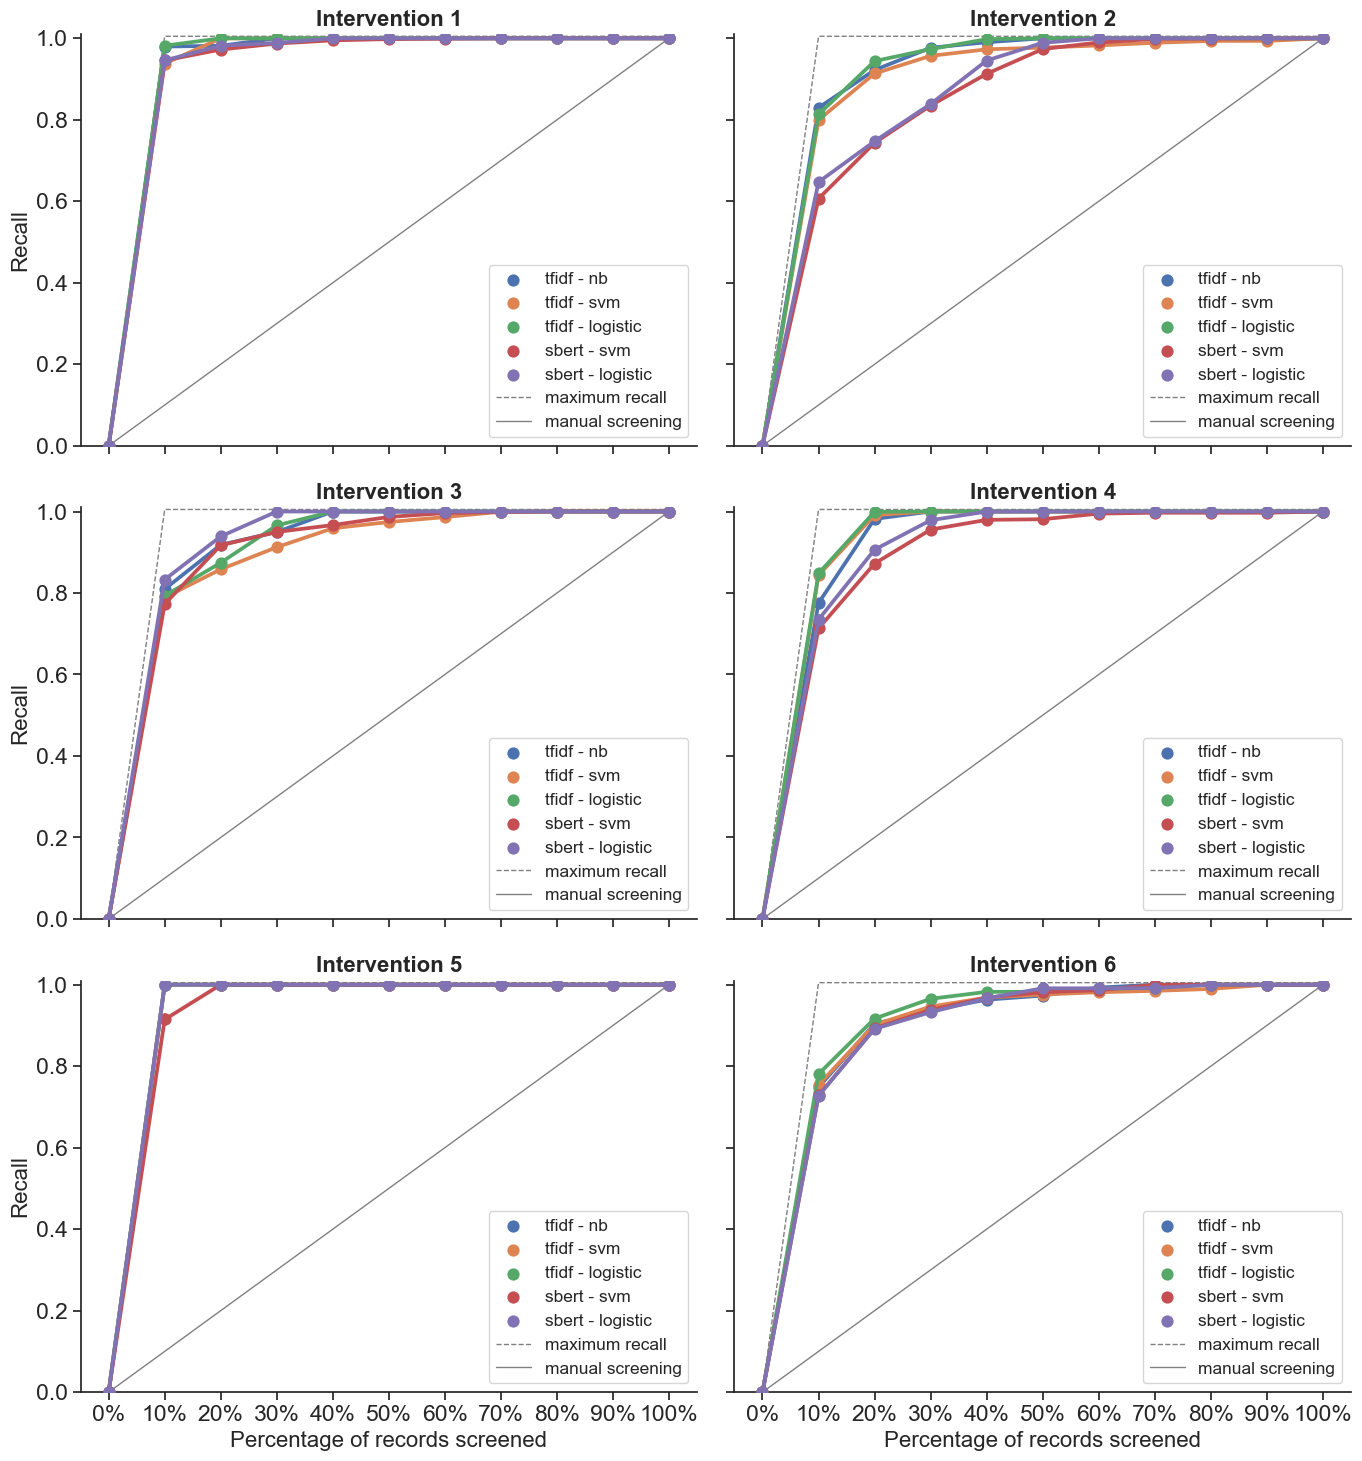

In [161]:
subset_reviews = ['Int']
generate_lineplots(df_prop_ed, df_max_recalls_ed, subset_reviews)

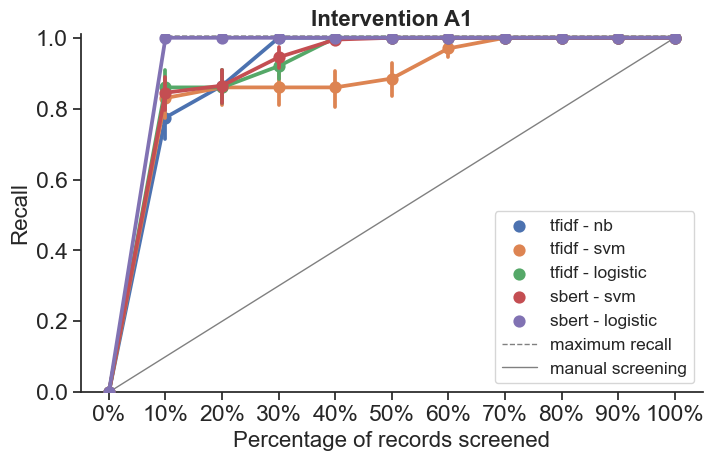

In [166]:
subset_reviews = ['Int8']
generate_lineplots(df_prop, df_max_recalls, subset_reviews)

## Part III: Simulations with adapted review datasets

### 9. Variations in number of (relevant) records 

Create dataframes of manually adapted numbers of (relevant) records that were also used to simulate the semi-automated screening process on the High Performance Computer (HPC)

In [176]:
# Define a function to create a dictionary with subsets of a dataset consisting of varying numbers of records and inclusions:

def df_var_dict(review_name, df, sizes, incl_prop): 
    
    '''
    df (pandas.DataFrame):    a dataframe of a review with at least containing the columns 'abstract', 'title', and 'label_included'
    sizes (list):             a list of integers of dataframe sizes to vary  
    incl_prop (list):         a list of integers of inclusion proportions to vary 
    '''
    
    # First a list of possible size/inclusion combinations is created:
    unique_combinations = []
    for i in range(0, len(sizes)):
        unique_combinations.append([sizes[i],incl_prop[i]])

    # Then a dictionary is created with for each combination a sample of the dataset. If the sample cannot be retrieved,
    # i.e. the dataset size is too small or the inclusion proportion is not available, the respective item in the dictionary remains empty.
    df_dict = {}
    
    # For each combination of size/inclusion proportion:
    for i in range(len(unique_combinations)):
        # Check if the dataframe includes enough records to sample the respective size
        if len(df) >= unique_combinations[i][0]:
            
            
            # Check if the inclusion proportion is possible for the respective size
            if df.loc[df['label_included'] == 1].shape[0] >= int(unique_combinations[i][0] * unique_combinations[i][1]) and df.loc[df['label_included'] == 0].shape[0] >= int(unique_combinations[i][0] - (unique_combinations[i][0] * unique_combinations[i][1])):
                # If so:
                # Sample random inclusions
                incl = df.loc[df['label_included'] == 1].sample(n = int(unique_combinations[i][0] * unique_combinations[i][1]), replace = False, random_state = 1)
                # Sample random exclusions
                excl = df.loc[df['label_included'] == 0].sample(n = int(unique_combinations[i][0] - (unique_combinations[i][0] * unique_combinations[i][1])), replace = False, random_state = 1)
                # Create a dataframe of the inclusions and exclusions
                df_new = pd.concat([incl, excl]).sort_values('authors').reset_index()
                name = review_name + "_" + str(len(df_new)) + "_" + str(unique_combinations[i][1])
            # If the size/inclusion proportion is not possible, leave the dataframe empty
            else:
                name = review_name + "_" + str(len(df_new)) + "_" + str(unique_combinations[i][1])
                df_new = [] 
        else:
            df_new = []
        
        if len(df_new) > 0:
            if df_new['label_included'].sum() <= 10:
                df_new = []
        
        # Store the dataframe in the dictionary of all retrieved dataframes
        if len(df_new) > 0:
            df_dict[name] = df_new
  
    return(df_dict)

# Apply the function:
sizes = [500, 1000, 2000]
incl_prop = [0.1, 0.05, 0.025]
ss_dict = df_var_dict(review_name = 'Int1', df = dfs_int['Int1'], sizes = sizes, incl_prop = incl_prop)                 
ss_dict.update(df_var_dict(review_name = 'Int2', df = dfs_int['Int2'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Int4', df = dfs_int['Int4'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Int6', df = dfs_int['Int6'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Prog3', df = dfs_prog['Prog3'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Prog4', df = dfs_prog['Prog4'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Prog6', df = dfs_prog['Prog6'], sizes = sizes, incl_prop = incl_prop))
ss_dict.update(df_var_dict(review_name = 'Prog7', df = dfs_prog['Prog7'], sizes = sizes, incl_prop = incl_prop))

# Save the keys
ss_sims = list(ss_dict.keys())

### 10. Retrieve and merge the output from all simulations

In [179]:
# The resulting output from the HPC can then be retrieved and merged as follows:

train_models = [NaiveBayesClassifier()] 
feature_models = [Tfidf()]
query_models = [MaxQuery()]

# Create a list of the review-model combination names
sim_list_names_ss = []
for review in ss_sims:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                review_id = str(review + "_" + train_model.name + "_" + feature_model.name + "_" + query_model.name)
                sim_list_names_ss.append(review_id)

# Derive the results from the HPC retrieved pickle files with each having the rankings of a single simulation
multiple_sims_sizes = []
n_simulations = 200 # number of simulations per review-model combination
for i in range(0, len(sim_list_names_ss)):
    raw_output_ss = {}
    for j in range(1,n_simulations+1):
        if Path(path_results_HPC +'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names_ss[i], sim=j)).is_file():
            with open(path_results_HPC + 'sim_{review_id}_{sim}.p'.format(review_id=sim_list_names_ss[i], sim=j),'rb') as f:
                raw_output_ss.update(pickle.load(f))
    if len(raw_output_ss) > 0:
        multiple_sims_sizes.append((sim_list_names_ss[i], len(ss_dict['_'.join(sim_list_names_ss[0].split('_')[0:3])]), n_simulations, raw_output_ss))

In [ ]:
# Save (back-up) the file with the simulation results
# with open(path_results + 'multiple_sims_sizes_all_int-prog.p','wb') as f:
#     pickle.dump(multiple_sims_sizes, f)

In [ ]:
# Open the file with the simulation results
with open(path_results + 'multiple_sims_sizes_all_int-prog.p','rb') as f:
    multiple_sims_sizes = pickle.load(f)

### 11. Compute performance metrics from the retrieved simulation output

In [185]:
proportions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sample_sizes = list(map(int,list(np.linspace(0, 99, 100,retstep = True)[0]))) + list(map(int,list(np.linspace(100, 12400, 124,retstep = True)[0])))
n_simulations = 200

In [ ]:
# Use the compute_metrics function to compute the metrics from the retrieved simulation output
#raw_output_sizes = compute_metrics.compute_metrics(multiple_sims, proportions, sample_sizes)

In [ ]:
# Use the compute_nwss function to derive the normalized WSS of the retrieved simulation output
#raw_output_nwss_sizes = compute_nwss.compute_nwss(multiple_sims_sizes, proportions, sample_sizes)

In [ ]:
# Save (back-up) a file with the computed output
# with open(path_results + 'raw_output_sizes.p','wb') as f:
#     pickle.dump(raw_output_sizes, f)

In [ ]:
# Save (back-up) a file with the computed output
# with open(path_results + 'raw_output_nwss_sizes.p','wb') as f:
#     pickle.dump(raw_output_nwss_sizes, f)

In [182]:
# Open the files with the computed output
with open(path_results + 'sims_output_saved_all_perc_int-prog_final_extra.p','rb') as f:
    raw_output_sizes = pickle.load(f)
with open(path_results + 'sims_output_saved_all_perc_nwss_int-prog_final.p','rb') as f:
    raw_output_nwss_sizes = pickle.load(f)

### 12. Create raw tables with all performance metrics seperately

In [183]:
evaluation_sizes = {}
for i in range(0, len(raw_output_sizes)):
    evaluation_sizes[raw_output_sizes[i][0]] = []
    evaluation_sizes[raw_output_sizes[i][0]].append(raw_output_sizes[i][3:8])
    
evaluation_sizes_nwss = {}
for i in range(0, len(raw_output_nwss_sizes)):
    evaluation_sizes_nwss[raw_output_nwss_sizes[i][0]] = []
    evaluation_sizes_nwss[raw_output_nwss_sizes[i][0]].append(raw_output_nwss_sizes[i][3:8])

In [201]:
# Use the generate_recall_table_prop function to generate a table with all recall values for all proportions
df_prop_sizes = generate_recall_table_prop.generate_recall_table_prop(evaluation_sizes, proportions, n_simulations)

# Adapt the the column names
df_prop_sizes.rename(columns={'Train model': 'Records', 
                              'Feature model': 'Inclusions'}, inplace=True)
df_prop_sizes['Models'] = 'tfidf - nb'
df_prop_sizes['Review'] = df_prop_sizes.apply(lambda row: row['Review'] + '_' + str(row['Records']) + '_' + str(row['Inclusions']), axis=1)

df_prop_sizes.head()

,Review,Simulation number,Records,Inclusions,Query model,Simulation,percentage of records screened,recall,Review_full,Models
0,Int1_2000_0.025,1,2000,0.025,nb,Intervention 1 (2000 - 0.025),0%,0.000,Intervention 1,tfidf - nb
1,Int1_2000_0.025,1,2000,0.025,nb,Intervention 1 (2000 - 0.025),10%,0.925,Intervention 1,tfidf - nb
2,Int1_2000_0.025,1,2000,0.025,nb,Intervention 1 (2000 - 0.025),20%,0.975,Intervention 1,tfidf - nb
3,Int1_2000_0.025,1,2000,0.025,nb,Intervention 1 (2000 - 0.025),30%,1.000,Intervention 1,tfidf - nb
4,Int1_2000_0.025,1,2000,0.025,nb,Intervention 1 (2000 - 0.025),40%,1.000,Intervention 1,tfidf - nb


In [202]:
# Sort the dictionary
ss_dict_ord = collections.OrderedDict(sorted(ss_dict.items()))
# Use the max_recall_prop function to calculate the maximum achievable recall for each review
df_max_recalls_sizes = max_recall_prop.max_recall_prop(ss_dict_ord, proportions)
df_max_recalls_sizes.head()

,Review,Maximum recall
0,Int1_1000_0.05,0.0
1,Int1_1000_0.05,1.0
2,Int1_1000_0.05,1.0
3,Int1_1000_0.05,1.0
4,Int1_1000_0.05,1.0


### 13. Create boxplots/lineplots of increasing recall during screening (for results)

IndexError: list index out of range

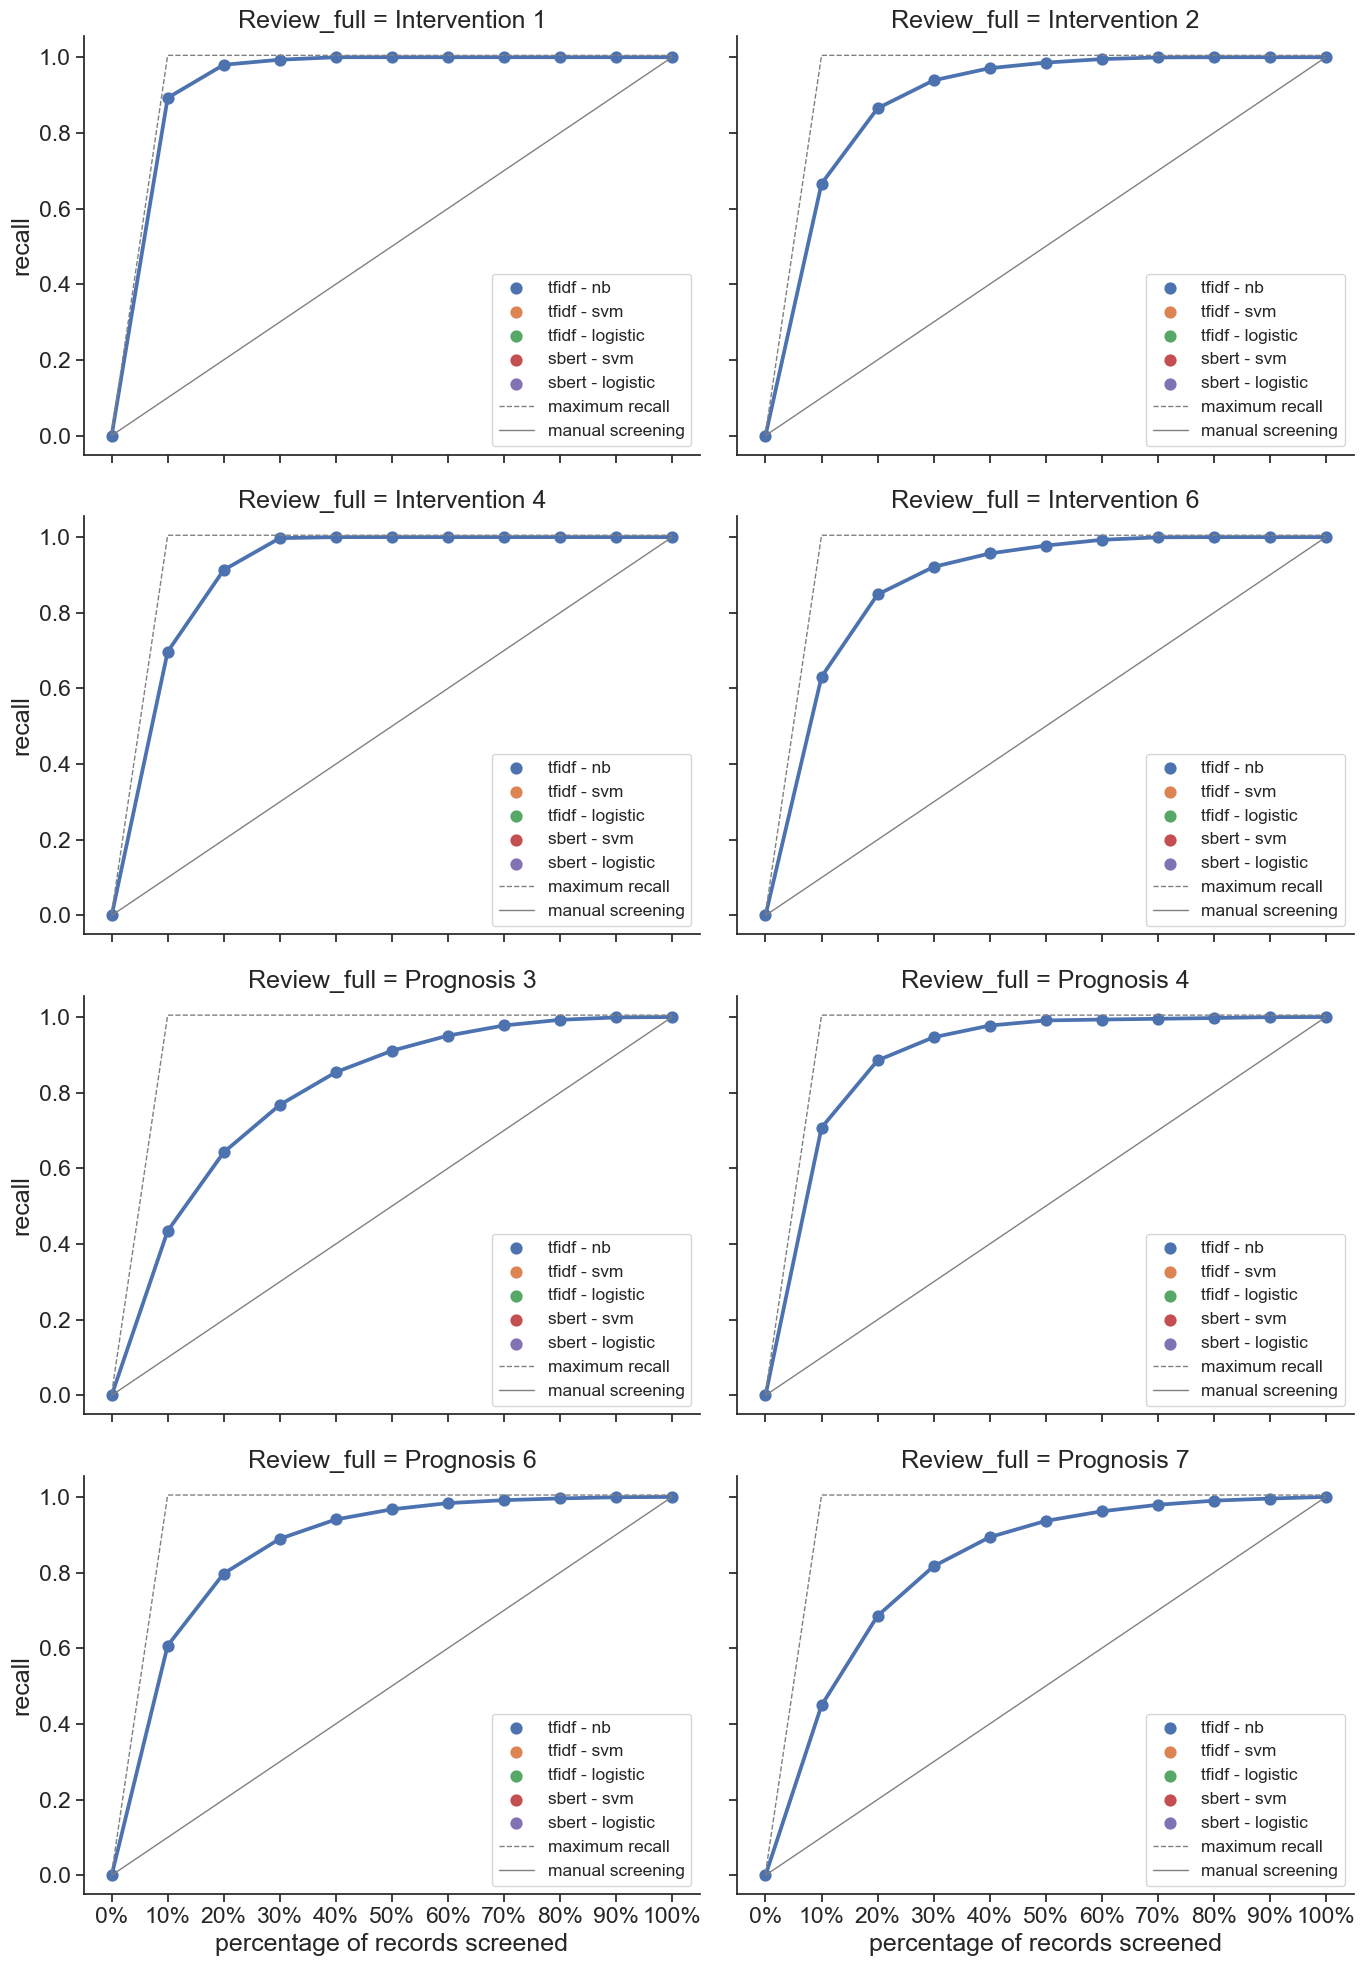

In [203]:
subset_reviews = ['Int1', 'Int2', 'Int4', 'Int6', 
                 'Prog3', 'Prog4', 'Prog6', 'Prog7']
generate_lineplots(df_prop_sizes, df_max_recalls_sizes, subset_reviews)

In [ ]:
# Lineplots with percentage on the x-axis
import math

# Optionally choose a subset to plot
subset = '2000'
df_prop_subset = df_prop[df_prop['Simulation'].str.contains(subset)]
df_max_recalls_ed = df_max_recalls_ss

# For prognosis run:
df_prop_subset = df_prop_subset[~df_prop_subset.Review_full.str.contains('Prognosis 5')]
df_prop_subset = df_prop_subset[~df_prop_subset.Review_full.str.contains('Prognosis 2')]
df_prop_subset = df_prop_subset[~df_prop_subset.Review_full.str.contains('Prognosis 1')]
df_prop_subset['Review_full'] = df_prop_subset['Review_full'].replace({'Prognosis 6': 'Prognosis 5',
                                                                       'Prognosis 7': 'Prognosis 6'})
df_prop_subset['Review'] = df_prop_subset['Review'].str.replace('Prog6', 'Prog5')
df_prop_subset['Review'] = df_prop_subset['Review'].str.replace('Prog7', 'Prog6')
df_prop_subset['Simulation'] = df_prop_subset['Simulation'].str.replace('Prognosis 6', 'Prognosis 5')
df_prop_subset['Simulation'] = df_prop_subset['Simulation'].str.replace('Prognosis 7', 'Prognosis 6')

df_max_recalls_ed = df_max_recalls_ed[~df_max_recalls_ed.Review.str.contains('Prog5')]
df_max_recalls_ed['Review'] = df_max_recalls_ed['Review'].str.replace('Prog6', 'Prog5')
df_max_recalls_ed['Review'] = df_max_recalls_ed['Review'].str.replace('Prog7', 'Prog6')

# Plot
p3 = sns.catplot(data = df_prop_subset, kind = 'point', 
                 x = 'percentage of records screened', y = 'recall', 
                 col = 'Simulation', hue = 'Models', errorbar = 'ci',
                 col_wrap = 2, aspect = 1.4, legend = False
                 )

axes = p3.fig.axes

for i in range(0, len(df_prop_subset['Review'].unique())): 
    max_recalls_per_prop = df_max_recalls_ed.loc[df_max_recalls_ed['Review'] == df_prop_subset['Review'].unique()[i]]['Maximum recall']    
    manual_screening = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    x_axis = df_prop_subset['percentage of records screened'][0:len(max_recalls_per_prop)]
    axes[i].plot(x_axis, max_recalls_per_prop + 0.005, 'k-', linewidth = 1, color = 'grey', linestyle = '--', label = "maximum recall") 
    axes[i].plot(x_axis, manual_screening, 'k-', linewidth = 1, color = 'grey', linestyle = '-', label = "manual screening") 
    axes[i].legend(loc="lower right", fontsize = 12.5)

p3.set_titles(col_template = "{col_name}", size = 16, weight = 'bold')
p3.set_xlabels('Percentage of records screened', size = 16)
p3.set_ylabels('Recall', size = 16)
p3.set(ylim = (0, 1.01))
plt.show()

In [ ]:
# Lineplots with percentage on the x-axis
import math

# Optionally choose a subset to plot
subset = '0.01'
df_prop_subset = df_prop[df_prop['Simulation'].str.contains(subset)]
df_max_recalls_ed = df_max_recalls_ss

print(df_max_recalls_ed['Review'].unique())

# For prognosis run:
df_prop_subset = df_prop_subset[~df_prop_subset.Review_full.str.contains('Prognosis 5')]
df_prop_subset['Review_full'] = df_prop_subset['Review_full'].replace({'Prognosis 6': 'Prognosis 5',
                                                                       'Prognosis 7': 'Prognosis 6'})
df_prop_subset['Review'] = df_prop_subset['Review'].str.replace('Prog6', 'Prog5')
df_prop_subset['Review'] = df_prop_subset['Review'].str.replace('Prog7', 'Prog6')
df_prop_subset['Simulation'] = df_prop_subset['Simulation'].str.replace('Prognosis 6', 'Prognosis 5')
df_prop_subset['Simulation'] = df_prop_subset['Simulation'].str.replace('Prognosis 7', 'Prognosis 6')


df_max_recalls_ed = df_max_recalls_ed[~df_max_recalls_ed.Review.str.contains('Prog5')]
df_max_recalls_ed['Review'] = df_max_recalls_ed['Review'].str.replace('Prog6', 'Prog5')
df_max_recalls_ed['Review'] = df_max_recalls_ed['Review'].str.replace('Prog7', 'Prog6')

df_prop_subset

In [ ]:
# Output table for precision

df_prec = pd.DataFrame()
length = n_simulations
for key, value in evaluation_sizes.items():
    names = key.split('_')
    review = [names[0]] * length
    n_records = [names[1]] * length
    rel_records = [names[2]] * length
    train_model = [names[3] + " & " + names[4]] * length
    simulations = range(1, n_simulations+1)
    precision = value[0][0]['Precision'] ###
    df_sim = pd.DataFrame(list(zip(review, n_records, rel_records, train_model, simulations, precision)),
                           columns = ['Review', 'Total records', 'Relevant records', 'Train model', 'Simulation', 'Precision@95%'])
    df_prec = pd.concat([df_prec, df_sim])

    df_prec = df_prec.reset_index(drop = True)

df_prec

In [ ]:
df_wss = pd.DataFrame()
length = n_simulations
for key, value in evaluation_sizes.items():
    names = key.split('_')
    review = [names[0]] * length
    n_records= [names[1]] * length
    rel_records = [names[2]] * length
    train_model = [names[3] + " & " + names[4]] * length
    simulations = range(1, n_simulations+1)
    wss = value[0][2]['WSS-95%']
    n_saved = value[0][3]['Workload reduction (records)']
    df_sim = pd.DataFrame(list(zip(review, n_records, rel_records, train_model, simulations, wss, n_saved)),
                           columns = ['Review', 'Total records', 'Relevant records', 'Train model', 'Simulation', 'WSS@95%', 'Workload reduction (n)'])
    df_wss = pd.concat([df_wss, df_sim])

    df_wss = df_wss.reset_index(drop = True)
    
df_wss

df_nwss = pd.DataFrame()
length = n_simulations
for key, value in evaluation_sizes_nwss.items():
    names = key.split('_')
    review = [names[0]] * length
    n_records = [names[1]] * length
    rel_records = [names[2]] * length
    train_model = [names[3] + " & " + names[4]] * length
    simulations = range(1, n_simulations+1)
    nwss = value[0][0]['nWSS-95%']
    df_sim = pd.DataFrame(list(zip(review, n_records, rel_records, train_model, simulations, nwss)),
                           columns = ['Review', 'Total records', 'Relevant records', 'Train model', 'Simulation', 'n-WSS@95%'])
    df_nwss = pd.concat([df_nwss, df_sim])

    df_nwss = df_nwss.reset_index(drop = True)

df_wss = pd.merge(df_wss[['Review', 'Total records', 'Relevant records', 'Train model', 'Simulation', 'WSS@95%', 'Workload reduction (n)']], 
                  df_nwss[['Review', 'Total records', 'Relevant records', 'Train model', 'Simulation', 'n-WSS@95%']],
                  how = 'left', on = ['Review', 'Total records', 'Relevant records', 'Train model', 'Simulation'])

df_wss = df_wss.reindex(columns = ['Review', 'Train model', 'Total records', 'Relevant records', 'Query model', 'Simulation', 'WSS@95%', 'n-WSS@95%', 'Workload reduction (n)']) ###
df_wss['Workload reduction (hours)'] = round((df_wss['Workload reduction (n)'] * 0.5 / 60), 1) ###
df_wss[0:20]

In [ ]:
# Output table for combined wss and precision (for results)
import math

df_wss_prec = pd.merge(df_wss, df_prec, on=['Review', 'Total records', 'Relevant records', 'Train model', 'Simulation'])

df1 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records', 'Train model'])['WSS@95%'].agg(Mean1 = 'mean',
                                                                                                         Count1 = 'count',
                                                                                                        SD1 = 'std').reset_index()

ci95_hi_1 = []
ci95_lo_1 = []

for i in df1.index:
    m, c, s = df1.loc[i][4:7]
    ci95_hi_1.append("{:.3f}".format(m + 1.96*s/math.sqrt(c)))
    ci95_lo_1.append("{:.3f}".format(m - 1.96*s/math.sqrt(c)))
df1['ci95_hi_1'] = ci95_hi_1
df1['ci95_lo_1'] = ci95_lo_1
df1['Mean1'] = df1['Mean1'].apply(lambda x: '{:,.3f}'.format(x)) #remove for plots

df2 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records', 'Train model'])['n-WSS@95%'].agg(Mean2 = 'mean',
                                                                                                           Count2 = 'count',
                                                                                                           SD2 = 'std').reset_index()

ci95_hi_2 = []
ci95_lo_2 = []

for i in df2.index:
    m, c, s = df2.loc[i][4:7]
    ci95_hi_2.append("{:.3f}".format(m + 1.96*s/math.sqrt(c)))
    ci95_lo_2.append("{:.3f}".format(m - 1.96*s/math.sqrt(c)))
df2['ci95_hi_2'] = ci95_hi_2
df2['ci95_lo_2'] = ci95_lo_2
df2['Mean2'] = df2['Mean2'].apply(lambda x: '{:,.3f}'.format(x)) #remove for plots

df3 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records', 'Train model'])['Precision@95%'].agg(Mean3 = 'mean',
                                                                                                               Count3 = 'count',
                                                                                                                SD3 = 'std').reset_index()
ci95_hi_3 = []
ci95_lo_3 = []

for i in df3.index:
    m, c, s = df3.loc[i][4:7]
    ci95_hi_3.append("{:.3f}".format(m + 1.96*s/math.sqrt(c)))
    ci95_lo_3.append("{:.3f}".format(m - 1.96*s/math.sqrt(c)))
df3['ci95_hi_3'] = ci95_hi_3
df3['ci95_lo_3'] = ci95_lo_3
df3['Mean3'] = df3['Mean3'].apply(lambda x: '{:,.3f}'.format(x)) #remove for plots

df4 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records', 'Train model'])['Workload reduction (n)'].agg(Mean4 = 'mean',
                                                                                     Count4 = 'count',
                                                                                     SD4 = 'std').reset_index()

ci95_hi_4 = []
ci95_lo_4 = []
for i in df4.index:
    m, c, s = df4.loc[i][4:7] ###
    ci95_hi_4.append("{:.0f}".format(m + 1.96*s/math.sqrt(c)))
    ci95_lo_4.append("{:.0f}".format(m - 1.96*s/math.sqrt(c)))
df4['ci95_hi_4'] = ci95_hi_4
df4['ci95_lo_4'] = ci95_lo_4
df4['Mean4'] = df4['Mean4'].apply(lambda x: '{:,.0f}'.format(x))

df5 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records', 'Train model'])['Workload reduction (hours)'].agg(Mean5 = 'mean',
                                                                                     Count5 = 'count',
                                                                                     SD5 = 'std').reset_index()

ci95_hi_5 = []
ci95_lo_5 = []

for i in df5.index:
    m, c, s = df5.loc[i][4:7] ###
    ci95_hi_5.append("{:.1f}".format(m + 1.96*s/math.sqrt(c)))
    ci95_lo_5.append("{:.1f}".format(m - 1.96*s/math.sqrt(c)))
df5['ci95_hi_5'] = ci95_hi_5
df5['ci95_lo_5'] = ci95_lo_5
df5['Mean5'] = df5['Mean5'].apply(lambda x: '{:,.1f}'.format(x))

df_wss_prec = pd.merge(df1[['Review', 'Total records', 'Relevant records', 'Train model', 'Mean1', 'ci95_hi_1', 'ci95_lo_1']], 
                       df2[['Review', 'Total records', 'Relevant records', 'Train model', 'Mean2', 'ci95_hi_2', 'ci95_lo_2']],
                       how = 'left', on = ['Review', 'Total records', 'Relevant records', 'Train model'])
df_wss_prec = pd.merge(df_wss_prec, 
                       df3[['Review', 'Total records', 'Relevant records', 'Train model', 'Mean3', 'ci95_hi_3', 'ci95_lo_3']], 
                       how = 'left', on = ['Review', 'Total records', 'Relevant records', 'Train model'])
df_wss_prec = pd.merge(df_wss_prec, 
                       df4[['Review', 'Total records', 'Relevant records', 'Train model', 'Mean4', 'ci95_hi_4', 'ci95_lo_4']], 
                       how = 'left', on = ['Review', 'Total records', 'Relevant records', 'Train model'])
df_wss_prec = pd.merge(df_wss_prec, 
                       df5[['Review', 'Total records', 'Relevant records', 'Train model', 'Mean5', 'ci95_hi_5', 'ci95_lo_5']], 
                       how = 'left', on = ['Review', 'Total records', 'Relevant records', 'Train model'])

df_wss_prec = df_wss_prec.drop(df_wss_prec[df_wss_prec['Review'] == 'Prog5'].index)
df_wss_prec['Review'] = df_wss_prec['Review'].replace({'Prog6': 'Prog5',
                                                       'Prog7': 'Prog6'})

# # df_wss_prec['WSS@95%recall (CI)'] = df_wss_prec["Mean1"] + " (" + df_wss_prec["ci95_lo_1"].astype(str) + "-" + df_wss_prec["ci95_hi_1"].astype(str) + ")"
# # df_wss_prec['n-WSS@95%recall (CI)'] = df_wss_prec["Mean2"] + " (" + df_wss_prec["ci95_lo_2"].astype(str) + "-" + df_wss_prec["ci95_hi_2"].astype(str) + ")"
# # df_wss_prec['Precision@95%recall (CI)'] = df_wss_prec["Mean3"] + " (" + df_wss_prec["ci95_lo_3"].astype(str) + "-" + df_wss_prec["ci95_hi_3"].astype(str) + ")"

# #df_wss_prec['Models'] = df_wss_prec['Feature model'] + " - " + df_wss_prec['Train model']
# sns.barplot(hue='Review',
#             y='Mean3', 
#             x='Relevant records', 
#             data=df_wss_prec).set(ylabel='Precision@0.95recall',ylim=(0,0.5))
# plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.show()

# #df_wss_prec['Models'] = df_wss_prec['Feature model'] + " - " + df_wss_prec['Train model']
# sns.barplot(hue='Review',
#             y='Mean1', 
#             x='Relevant records', 
#             data=df_wss_prec).set(ylabel='WSS@0.95recall', ylim=(0,1))
# plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.show()

# #df_wss_prec['Models'] = df_wss_prec['Feature model'] + " - " + df_wss_prec['Train model']
# sns.barplot(hue='Review',
#             y='Mean2', 
#             x='Relevant records', 
#             data=df_wss_prec).set(ylabel='nWSS@0.95recall', ylim=(0,1))
# plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plt.show()

# remove for plots:
df_wss_prec['WSS@95%recall (CI)'] = df_wss_prec["Mean1"] + " (" + df_wss_prec["ci95_lo_1"].astype(str) + "-" + df_wss_prec["ci95_hi_1"].astype(str) + ")"
df_wss_prec['n-WSS@95%recall (CI)'] = df_wss_prec["Mean2"] + " (" + df_wss_prec["ci95_lo_2"].astype(str) + "-" + df_wss_prec["ci95_hi_2"].astype(str) + ")"
df_wss_prec['Precision@95%recall (CI)'] = df_wss_prec["Mean3"] + " (" + df_wss_prec["ci95_lo_3"].astype(str) + "-" + df_wss_prec["ci95_hi_3"].astype(str) + ")"
df_wss_prec['Workload reduction in record numbers (CI)'] = df_wss_prec["Mean4"] + " (" + df_wss_prec["ci95_lo_4"].astype(str) + "-" + df_wss_prec["ci95_hi_4"].astype(str) + ")"
df_wss_prec['Workload reduction in hours (CI)'] = df_wss_prec["Mean5"] + " (" + df_wss_prec["ci95_lo_5"].astype(str) + "-" + df_wss_prec["ci95_hi_5"].astype(str) + ")"

df_wss_prec.drop(['Mean1', 'ci95_hi_1', 'ci95_lo_1', 'Mean2', 'ci95_hi_2', 'ci95_lo_2', 'Mean3', 'ci95_hi_3', 'ci95_lo_3', 'Mean4', 'ci95_hi_4', 'ci95_lo_4',  'Mean5', 'ci95_hi_5', 'ci95_lo_5'], axis=1, inplace=True)

#df_wss_prec.drop(['Mean1', 'ci95_hi_1', 'ci95_lo_1', 'Mean2', 'ci95_hi_2', 'ci95_lo_2', 'Mean3', 'ci95_hi_3', 'ci95_lo_3'], axis=1, inplace=True)

df_wss_prec['Total records'] = df_wss_prec['Total records'].astype(int)
df_wss_prec['Relevant records'] = df_wss_prec['Relevant records'].astype(float)
df_wss_prec.loc[df_wss_prec['Relevant records'] >= 0, 'Relevant records'] = str(500)
df_wss_prec = df_wss_prec.sort_values(by=['Review', 'Total records'])

df_wss_prec.to_excel('Table_WSS_precision_sizes_final_extra.xlsx')
df_wss_prec

In [ ]:
# Figures for wss and precision (for results)
import math

df_wss_prec = pd.merge(df_wss, df_prec, on=['Review', 'Total records', 'Relevant records', 'Train model', 'Simulation'])

df1 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records', 'Train model'])['WSS@95%'].agg(Mean1 = 'mean',
                                                                                                         Count1 = 'count',
                                                                                                        SD1 = 'std').reset_index()

ci95_hi_1 = []
ci95_lo_1 = []

for i in df1.index:
    m, c, s = df1.loc[i][4:7]
    ci95_hi_1.append("{:.3f}".format(m + 1.96*s/math.sqrt(c)))
    ci95_lo_1.append("{:.3f}".format(m - 1.96*s/math.sqrt(c)))
df1['ci95_hi_1'] = ci95_hi_1
df1['ci95_lo_1'] = ci95_lo_1

df2 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records', 'Train model'])['n-WSS@95%'].agg(Mean2 = 'mean',
                                                                                                           Count2 = 'count',
                                                                                                           SD2 = 'std').reset_index()

ci95_hi_2 = []
ci95_lo_2 = []

for i in df2.index:
    m, c, s = df2.loc[i][4:7]
    ci95_hi_2.append("{:.3f}".format(m + 1.96*s/math.sqrt(c)))
    ci95_lo_2.append("{:.3f}".format(m - 1.96*s/math.sqrt(c)))
df2['ci95_hi_2'] = ci95_hi_2
df2['ci95_lo_2'] = ci95_lo_2

df3 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records', 'Train model'])['Precision@95%'].agg(Mean3 = 'mean',
                                                                                                               Count3 = 'count',
                                                                                                                SD3 = 'std').reset_index()
ci95_hi_3 = []
ci95_lo_3 = []

for i in df3.index:
    m, c, s = df3.loc[i][4:7]
    ci95_hi_3.append("{:.3f}".format(m + 1.96*s/math.sqrt(c)))
    ci95_lo_3.append("{:.3f}".format(m - 1.96*s/math.sqrt(c)))
df3['ci95_hi_3'] = ci95_hi_3
df3['ci95_lo_3'] = ci95_lo_3

df_wss_prec = pd.merge(df1[['Review', 'Total records', 'Relevant records', 'Train model', 'Mean1', 'ci95_hi_1', 'ci95_lo_1']], 
                       df2[['Review', 'Total records', 'Relevant records', 'Train model', 'Mean2', 'ci95_hi_2', 'ci95_lo_2']],
                       how = 'left', on = ['Review', 'Total records', 'Relevant records', 'Train model'])
df_wss_prec = pd.merge(df_wss_prec, 
                       df3[['Review', 'Total records', 'Relevant records', 'Train model', 'Mean3', 'ci95_hi_3', 'ci95_lo_3']], 
                       how = 'left', on = ['Review', 'Total records', 'Relevant records', 'Train model'])

df_wss_prec = df_wss_prec.drop(df_wss_prec[df_wss_prec['Review'] == 'Prog5'].index)
df_wss_prec['Review'] = df_wss_prec['Review'].replace({'Prog6': 'Prog5',
                                                       'Prog7': 'Prog6'})

df_wss_prec = df_wss_prec.drop(df_wss_prec[df_wss_prec['Review'] == 'Prog1'].index)
df_wss_prec = df_wss_prec.drop(df_wss_prec[df_wss_prec['Review'] == 'Prog2'].index)

subset = 'Prog'
df_wss_prec = df_wss_prec[df_wss_prec['Review'].str.contains(subset)]

sns.barplot(hue='Review',
            y='Mean3', 
            x='Total records', 
            order = ['500','1000','2000'],
            data=df_wss_prec).set(ylabel='Precision@0.95recall',ylim=(0,0.5))
plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

sns.barplot(hue='Review',
            y='Mean1', 
            x='Total records', 
            order = ['500','1000','2000'],
            data=df_wss_prec).set(ylabel='WSS@0.95recall', ylim=(0,1))
plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

sns.barplot(hue='Review',
            y='Mean2', 
            x='Total records', 
            order = ['500','1000','2000'],
            data=df_wss_prec).set(ylabel='nWSS@0.95recall', ylim=(0,1))
plt.legend(fontsize='10', title_fontsize='14', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
# Output table for combined wss and precision (for results)

df_wss_prec = pd.merge(df_wss, df_prec, on=['Review', 'Total records', 'Relevant records', 'Query model', 'Simulation'])
df_wss_prec.drop(['Query model'], axis=1, inplace=True)

df1 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records'])['WSS@95%'].agg(Mean1 = 'mean',
                                                                                     SD1 = 'std').reset_index()
df3 = df_wss_prec.groupby(['Review', 'Total records', 'Relevant records'])['Precision@95%'].agg(Mean3 = 'mean',
                                                                                           SD3 = 'std').reset_index()
    
df_wss_prec = pd.merge(df1[['Review', 'Total records', 'Relevant records', 'Mean1', 'SD1']], 
                       df3[['Review', 'Total records', 'Relevant records', 'Mean3', 'SD3']],
                       how = 'left', on = ['Review', 'Total records', 'Relevant records'])

df_wss_prec['WSS@95%recall (mean \u00B1 sd)'] = round(df_wss_prec["Mean1"], 2).astype(str) + u" \u00B1 " + round(df_wss_prec["SD1"], 2).astype(str)
df_wss_prec['Precision@95%recall (mean \u00B1 sd)'] = round(df_wss_prec["Mean3"], 2).astype(str) + u" \u00B1 " + round(df_wss_prec["SD3"], 2).astype(str)
df_wss_prec.drop(['Mean1', 'SD1', 'Mean3', 'SD3'], axis=1, inplace=True)
df_wss_prec.to_excel('Table_WSS_Precision_sizes.xlsx')
df_wss_prec

In [ ]:
# Derive a table of the recall at different proportions of screened records
# TODO cleanup

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

evaluation_sizes = {}
for i in range(0, len(multiple_sims_sizes)):
    evaluation_sizes[multiple_sims_sizes[i][0]] = []
    evaluation_sizes[multiple_sims_sizes[i][0]].append(multiple_sims_sizes[i][3:7])
    
n_simulations = 10
prop_start = 0.1
prop_end = 0.9
prop_steps = 9

steps = np.linspace(prop_start*100, prop_end*100, prop_steps, retstep = True)[0]
proportions = []
for i in range(0, len(steps)):
    proportions.append(str(int(steps[i])) + '%')

inclusion_proportion = [0.05, 0.10, 0.15, 0.20, 0.25, 0.05, 0.10, 0.15, 0.20, 0.25, 0.05, 0.10, 0.15, 0.20, 0.25, 0.05, 0.10, 0.15, 0.20, 0.25, 0.05, 0.10, 0.15, 0.20, 0.25, 0.05, 0.10, 0.15, 0.20, 0.25, 0.05, 0.10, 0.15, 0.20, 0.25]

df = pd.DataFrame()
length = len(proportions) * n_simulations
for i in range(0, len(output_sizes)):
    names = [output_sizes[i][0]] * length
    size = [output_sizes[i][1]] * length
    #inclusions = inclusion_proportion
    inclusions = []
    for i in [0.05, 0.10, 0.15, 0.20, 0.25]:
        inclusions.append(list(np.repeat(i, n_simulations)))
    inclusions = [item for sublist in inclusions for item in sublist] 
    props = proportions * n_simulations
    simulations = []
    for i in range(1, n_simulations+1):
        simulations.append(list(np.repeat(i, len(proportions))))
    simulations = [item for sublist in simulations for item in sublist]
    recalls_props = output_sizes[i][3]['Recall'] #[item for sublist in value[0][0] for item in sublist]
    df_sim = pd.DataFrame(list(zip(size,inclusions,simulations,props,recalls_props)),
                       columns = ['Review size', 'Inclusion proportion', 'Simulation', 'Percentage of records screened','Recall'])
    df = pd.concat([df, df_sim])

df = df.groupby(['Review size', 'Inclusion proportion', 'Percentage of records screened'])['Recall'].agg(Mean = 'mean',
                                                   SD = 'std').sort_values('Review size').reset_index()
df['Mean_SD'] = round(df["Mean"], 2).astype(str) + u" \u00B1 " + round(df["SD"], 2).astype(str)
df = df.round(2)
df = df.pivot(index = ['Review size', 'Inclusion proportion'], columns='Percentage of records screened', values='Mean').reset_index()
df = df.rename_axis(None, axis=1)

df

In [ ]:
####################################################################################################################

In [ ]:
multiple_sims = []
for review in review_dic:
    for train_model in train_models:
        for feature_model in feature_models:
            for query_model in query_models:
                sim = [review, train_model, feature_model, query_model]
                multiple_sims.append(sim)



In [ ]:
str(multiple_sims[0][1])

In [ ]:
ASReview_simulation(review_id = multiple_sims[1][0], review_data = dfs_prog[multiple_sims[1][0]], 
                        path_name = path_name,
                        train_model = multiple_sims[1][1], query_model = multiple_sims[1][3], 
                        balance_model = DoubleBalance(), feature_model = multiple_sims[1][2], 
                        n_simulations = 10, #100
                        n_model_update = 10, n_prior_included = 10, n_prior_excluded = 10)